<a href="https://colab.research.google.com/github/samjang03/Planetary_Guide_Servlet_Project/blob/main/bg_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
from itertools import product
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Datasets/'

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv(path + 'train.csv', index_col='id', parse_dates=['time'])
df_test = pd.read_csv(path + 'test.csv', index_col='id', parse_dates=['time'])
activities = pd.read_csv(path + 'activities.txt')
print("\nПерші рядки train:")
print(df_train.head())

print("\nРозмір тренувального набору:", df_train.shape)
print("Розмір тестового набору:", df_test.shape)

<ipython-input-6-2b444c68a848>:1: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(path + 'train.csv', index_col='id', parse_dates=['time'])
<ipython-input-6-2b444c68a848>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train = pd.read_csv(path + 'train.csv', index_col='id', parse_dates=['time'])
<ipython-input-6-2b444c68a848>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, ple


Перші рядки train:
      p_num                time  bg-5:55  bg-5:50  bg-5:45  bg-5:40  bg-5:35  \
id                                                                             
p01_0   p01 2025-03-14 06:10:00      NaN      NaN      9.6      NaN      NaN   
p01_1   p01 2025-03-14 06:25:00      NaN      NaN      9.7      NaN      NaN   
p01_2   p01 2025-03-14 06:40:00      NaN      NaN      9.2      NaN      NaN   
p01_3   p01 2025-03-14 06:55:00      NaN      NaN      8.7      NaN      NaN   
p01_4   p01 2025-03-14 07:10:00      NaN      NaN      8.4      NaN      NaN   

       bg-5:30  bg-5:25  bg-5:20  ...  activity-0:40  activity-0:35  \
id                                ...                                 
p01_0      9.7      NaN      NaN  ...            NaN            NaN   
p01_1      9.2      NaN      NaN  ...            NaN            NaN   
p01_2      8.7      NaN      NaN  ...            NaN            NaN   
p01_3      8.4      NaN      NaN  ...            NaN            

## Базовий аналіз струкури даних

In [ ]:
def analyze_dataset(df, name="Dataset"):
    """
    Функція для аналізу структури набору даних

    Parameters:
    df (DataFrame): набір даних для аналізу
    name (str): назва набору даних для виведення

    Returns:
    dict: словник з назвами колонок різних типів даних
    """
    print(f"\n{name} Analysis:")
    print("-" * 50)
    print(f"Shape: {df.shape}")

    print("\nColumns by type:")
    print(df.dtypes.value_counts())

    # Аналіз пропущених значень з відсотками
    print("\nMissing values:")
    missing = df.isnull().sum()
    missing_percent = (df.isnull().sum() / len(df)) * 100
    missing_data = pd.DataFrame({
        'Missing Values': missing[missing > 0],
        'Percent': missing_percent[missing > 0]
    }).round(2)
    print(missing_data)

    # Групуємо колонки за типами даних
    bg_cols = [col for col in df.columns if 'bg' in col.lower()]
    insulin_cols = [col for col in df.columns if 'insulin' in col.lower()]
    carbs_cols = [col for col in df.columns if 'carbs' in col.lower()]
    activity_cols = [col for col in df.columns if 'activity' in col.lower()]

    print("\nFeature groups:")
    print(f"Blood glucose columns: {len(bg_cols)}")
    print(f"Insulin columns: {len(insulin_cols)}")
    print(f"Carbohydrate columns: {len(carbs_cols)}")
    print(f"Activity columns: {len(activity_cols)}")

    return {
        'bg_cols': bg_cols,
        'insulin_cols': insulin_cols,
        'carbs_cols': carbs_cols,
        'activity_cols': activity_cols
    }

In [ ]:
def analyze_value_ranges(df):
    """
    Функція для аналізу діапазонів значень у наборі даних

    Parameters:
    df (DataFrame): набір даних для аналізу

    Returns:
    dict: словник зі статистичними показниками для різних груп даних
    """
    # Виділення колонок для різних типів даних
    bg_cols = [col for col in df.columns if 'bg' in col and col != 'bg+1:00']
    insulin_cols = [col for col in df.columns if 'insulin' in col]
    carbs_cols = [col for col in df.columns if 'carbs' in col]

    # Розрахунок статистик
    bg_stats = df[bg_cols].describe()
    insulin_stats = df[insulin_cols].describe()
    carbs_stats = df[carbs_cols].describe()
    target_stats = df['bg+1:00'].describe() if 'bg+1:00' in df.columns else None

    # Додаткова статистика по прийомам їжі
    nonzero_carbs = df[carbs_cols][df[carbs_cols] > 0]
    carbs_summary = {
        'total_meals': (df[carbs_cols] > 0).any(axis=1).sum(),
        'avg_meal_size': nonzero_carbs.mean().mean() if not nonzero_carbs.empty else 0,
        'max_meal_size': df[carbs_cols].max().max()
    }

    print("Статистика значень глюкози:")
    print(bg_stats.round(2))

    print("\nСтатистика значень інсуліну:")
    print(insulin_stats.round(2))

    print("\nСтатистика значень вуглеводів:")
    print(carbs_stats.round(2))

    if target_stats is not None:
        print("\nСтатистика цільової змінної:")
        print(target_stats.round(2))

    return {
        'bg_stats': bg_stats,
        'insulin_stats': insulin_stats,
        'carbs_stats': carbs_stats,
        'target_stats': target_stats,
        'carbs_summary': carbs_summary
    }

# Використання функцій
print("Аналіз наборів даних:")
train_features = analyze_dataset(df_train, "Training Dataset")
test_features = analyze_dataset(df_test, "Test Dataset")

print("\nАналіз діапазонів значень:")
train_stats = analyze_value_ranges(df_train)

Аналіз наборів даних:

Training Dataset Analysis:
--------------------------------------------------
Shape: (177024, 507)

Columns by type:
float64           433
object             73
datetime64[ns]      1
Name: count, dtype: int64

Missing values:
               Missing Values  Percent
bg-5:55                 27254    15.40
bg-5:50                 18491    10.45
bg-5:45                 13660     7.72
bg-5:40                 27258    15.40
bg-5:35                 18770    10.60
...                       ...      ...
activity-0:20          174270    98.44
activity-0:15          174293    98.46
activity-0:10          174287    98.45
activity-0:05          174271    98.44
activity-0:00          174287    98.45

[504 rows x 2 columns]

Feature groups:
Blood glucose columns: 73
Insulin columns: 72
Carbohydrate columns: 72
Activity columns: 72

Test Dataset Analysis:
--------------------------------------------------
Shape: (3644, 506)

Columns by type:
float64           432
object          

### Обробка пропущених значень

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from itertools import product

# Замініть несумісні назви стовпців
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

# Визначення назв стовпців для різних типів даних
hours = range(0, 6)   # Останні 6 годин
minutes = range(0, 60, 5)  # Кожні 5 хвилин

# Генерування назв стовпців
bg_cols = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)]
activity_cols = [col for col in df_train.columns if 'activity-' in col]

# Перетворення часових даних
for df in [df_train, df_test]:
    df['time'] = pd.to_datetime(df['time'])

# 1.1 Обробка пропущених значень для даних про глюкозу
print("Обробка пропущених значень у даних про глюкозу...")
for df in [df_train, df_test]:
    # Використовуємо лінійну інтерполяцію для даних про глюкозу
    # з обмеженням кількості послідовних пропусків (limit=3)
    df[bg_cols] = df[bg_cols].interpolate(method='linear', limit_direction='both', limit=3, axis=1)

# 1.2 Обробка пропущених значень для даних про інсулін та вуглеводи
print("Обробка пропущених значень у даних про інсулін та вуглеводи...")
for df in [df_train, df_test]:
    # Для інсуліну та вуглеводів пропущені значення зазвичай означають відсутність введення/вживання
    df[insu_cols] = df[insu_cols].fillna(0)
    df[carb_cols] = df[carb_cols].fillna(0)

# 1.3 Обробка пропущених значень для даних про активність
print("Обробка пропущених значень у даних про активність...")
for col in activity_cols:
    df_train[col] = df_train[col].fillna('None')
    df_test[col] = df_test[col].fillna('None')

# Код для виведення прикладу оброблених даних
print("\nПриклад оброблених даних після обробки пропущених значень:")
# Вибір основних стовпців для демонстрації (обмежуємо кількість для читабельності)
sample_bg_cols = bg_cols[:3]  # Перші 3 колонки з даними про глюкозу
sample_insu_cols = insu_cols[:2]  # Перші 2 колонки з даними про інсулін
sample_carb_cols = carb_cols[:2]  # Перші 2 колонки з даними про вуглеводи
sample_activity_cols = activity_cols[:2]  # Перші 2 колонки з даними про активність

# Формування набору стовпців для демонстрації
display_cols = ['p_num', 'time'] + sample_bg_cols + sample_insu_cols + sample_carb_cols + sample_activity_cols

# Виведення зразка даних
print(df_train[display_cols].head())

# Статистика оброблених даних (для перших колонок кожного типу)
print("\nСтатистика після обробки пропущених значень:")
print("\nДані про глюкозу:")
print(df_train[sample_bg_cols].describe())

print("\nДані про інсулін:")
print(df_train[sample_insu_cols].describe())

print("\nДані про вуглеводи:")
print(df_train[sample_carb_cols].describe())

Обробка пропущених значень у даних про глюкозу...
Обробка пропущених значень у даних про інсулін та вуглеводи...
Обробка пропущених значень у даних про активність...

Приклад оброблених даних після обробки пропущених значень:
      p_num                time  bg-0-00    bg-0-05    bg-0-10  insulin-0-00  \
id                                                                             
p01_0   p01 2025-03-07 06:10:00 -0.11022  15.466667  15.833333        0.0417   
p01_1   p01 2025-03-07 06:25:00 -0.11022  14.633333  14.866667        0.0417   
p01_2   p01 2025-03-07 06:40:00 -0.11022  14.066667  14.233333        0.0417   
p01_3   p01 2025-03-07 06:55:00 -0.11022  13.833333  13.866667        0.0417   
p01_4   p01 2025-03-07 07:10:00 -0.11022  13.533333  13.666667        0.0417   

       insulin-0-05  carbs-0-00  carbs-0-05  activity-5-55  activity-5-50  
id                                                                         
p01_0        0.0417         0.0         0.0              6   


Time in Range аналіз:
Тяжка гіпоглікемія: 0.0%
Гіпоглікемія: 0.1%
Цільовий діапазон: 82.4%
Гіперглікемія: 15.6%
Тяжка гіперглікемія: 1.9%


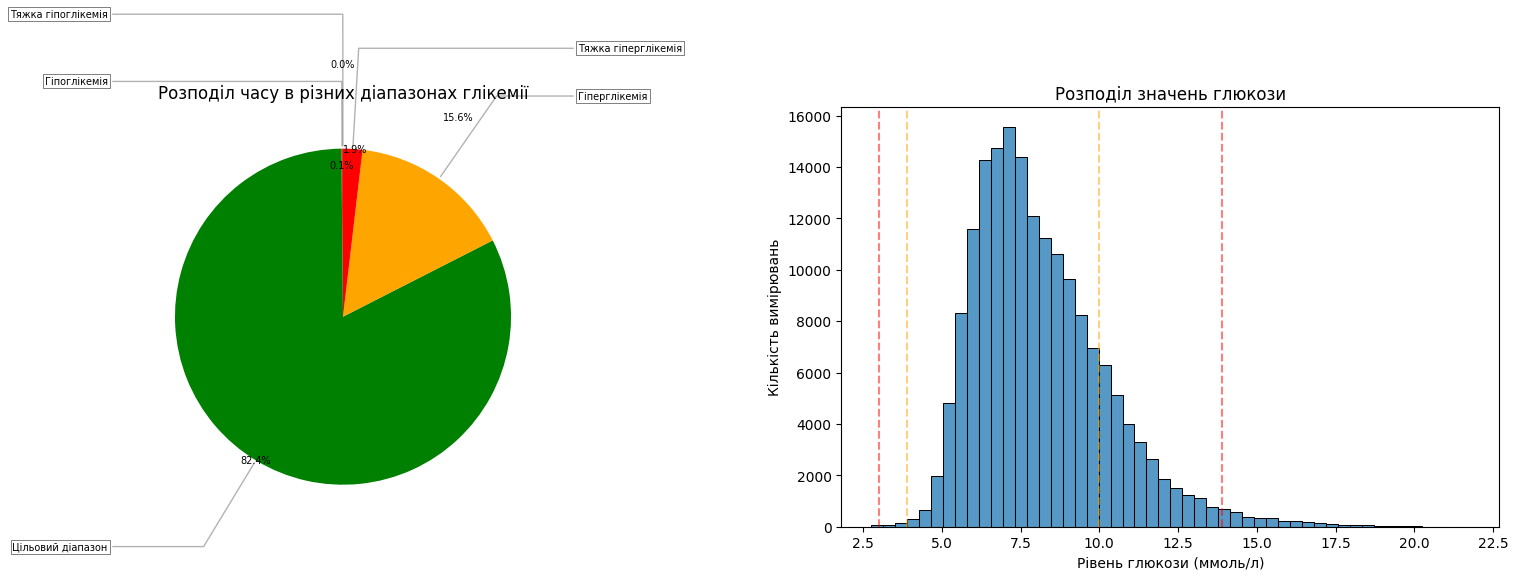

In [ ]:
def analyze_time_in_range(df, column='bg-0:00'):
    """
    Аналіз Time in Range для глюкози
    """
    # Визначення діапазонів згідно з міжнародними рекомендаціями
    ranges = {
        'Тяжка гіпоглікемія': (0, 3.0),
        'Гіпоглікемія': (3.0, 3.9),
        'Цільовий діапазон': (3.9, 10.0),
        'Гіперглікемія': (10.0, 13.9),
        'Тяжка гіперглікемія': (13.9, float('inf'))
    }

    # Розрахунок часу в кожному діапазоні
    time_in_range = {}
    total_valid = df[column].notna().sum()

    for name, (min_val, max_val) in ranges.items():
        mask = (df[column] >= min_val) & (df[column] < max_val)
        percentage = (mask.sum() / total_valid * 100).round(2)
        time_in_range[name] = percentage

    return pd.Series(time_in_range)

def plot_time_in_range_analysis(df, column='bg-0:00'):
    """
    Візуалізація аналізу Time in Range
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Time in Range діаграма
    time_in_range = analyze_time_in_range(df, column)
    colors = ['black', 'red', 'green', 'orange', 'red']

    # Створення кругової діаграми з правильним розміщенням міток
    wedges, texts = ax1.pie(
        time_in_range.values,
        labels=None,  # Прибираємо вбудовані мітки
        colors=colors,
        startangle=90
    )

    # Додаткове ручне розміщення відсоткових міток
    manual_offsets = {
        0: (1.2, 0.3),   # Тяжка гіпоглікемія
        1: (1.2, -0.3),  # Гіпоглікемія
        2: (1.0, 0),     # Цільовий діапазон
        3: (1.2, 0.2),   # Гіперглікемія
        4: (1.2, -0.2)   # Тяжка гіперглікемія
    }

    for i, (wedge, label) in enumerate(zip(wedges, time_in_range.index)):
        ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        # Розміщення відсоткової мітки
        offset_x, offset_y = manual_offsets[i]
        ax1.text(x*offset_x, y*offset_x + offset_y, f'{time_in_range.values[i]:.1f}%',
                 ha='center', va='center', fontsize=7)

    # Додавання правильних міток
    bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="k", lw=0.5, alpha=0.7)
    kw = dict(arrowprops=dict(arrowstyle="-", color='gray', alpha=0.6),
              bbox=bbox_props, zorder=0, va="center", fontsize=7)

    y_offsets = [0.2, -0.2, 0, 0, 0]

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        x_multiplier = 1.4
        y_multiplier = 1.6

        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw['arrowprops'].update({"connectionstyle": connectionstyle})

        ax1.annotate(time_in_range.index[i],
                     xy=(x, y),
                     xytext=(x_multiplier*np.sign(x), y_multiplier*y + y_offsets[i]),
                     horizontalalignment=horizontalalignment,
                     **kw)

    ax1.set_title('Розподіл часу в різних діапазонах глікемії')

    # Графік розподілу значень глюкози
    sns.histplot(data=df, x=column, bins=50, ax=ax2)

    # Додавання вертикальних ліній для діапазонів
    ax2.axvline(x=3.0, color='r', linestyle='--', alpha=0.5)
    ax2.axvline(x=3.9, color='orange', linestyle='--', alpha=0.5)
    ax2.axvline(x=10.0, color='orange', linestyle='--', alpha=0.5)
    ax2.axvline(x=13.9, color='r', linestyle='--', alpha=0.5)

    ax2.set_title('Розподіл значень глюкози')
    ax2.set_xlabel('Рівень глюкози (ммоль/л)')
    ax2.set_ylabel('Кількість вимірювань')

    plt.tight_layout()
    return fig

def analyze_and_plot_glucose_data(df, pattern='bg-'):
    """
    Комплексний аналіз даних глюкози з використанням усіх bg- колонок
    """
    # Знаходимо всі колонки з bg-
    bg_columns = [col for col in df.columns if pattern in col]

    # Створюємо колонку з середніми значеннями
    df_analysis = df.copy()
    df_analysis['mean_glucose'] = df[bg_columns].mean(axis=1)

    # Розрахунок метрик
    tir = analyze_time_in_range(df_analysis, column='mean_glucose')
    # variability = calculate_variability_metrics(df_analysis, column='mean_glucose')

    # Виведення результатів
    print("\nTime in Range аналіз:")
    print("="*50)
    for range_name, percentage in tir.items():
        print(f"{range_name}: {percentage:.1f}%")

    # print("\nМетрики варіабельності:")
    # print("="*50)
    # for metric_name, value in variability.items():
    #     print(f"{metric_name}: {value}")

    # Створення візуалізації
    fig = plot_time_in_range_analysis(df_analysis, column='mean_glucose')

    return tir, variability, fig

# Виклик функції
tir, variability, fig = analyze_and_plot_glucose_data(df_train)
plt.show()

### Створення ознак


In [ ]:
print("\nСтворення нових ознак...")

# 3.1 Додавання часових ознак
print("Додавання циклічних часових ознак...")
for df in [df_train, df_test]:
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute

    # Циклічне перетворення часу (синус та косинус)
    df['sin_hour'] = np.sin(2 * np.pi * df['hour']/24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour']/24)
    df['sin_minute'] = np.sin(2 * np.pi * df['minute']/60)
    df['cos_minute'] = np.cos(2 * np.pi * df['minute']/60)

# 3.2 Розрахунок швидкості зміни глюкози
print("Розрахунок швидкості зміни рівня глюкози...")
df_train['glucose_rate'] = df_train['bg-0-00'].diff() / 5  # ммоль/л за 5 хв
df_test['glucose_rate'] = df_test['bg-0-00'].diff() / 5

# Початкове значення заміняємо на 0, оскільки для першого запису неможливо розрахувати швидкість
df_train['glucose_rate'] = df_train['glucose_rate'].fillna(0)
df_test['glucose_rate'] = df_test['glucose_rate'].fillna(0)

# 3.3 Розрахунок активного інсуліну та вуглеводів
print("Розрахунок активного інсуліну та вуглеводів...")
def calculate_active_components(df):
    # Розрахунок активного інсуліну з урахуванням фармакокінетики
    peak_insulin = df[[col for col in insu_cols if '0-' in col or '1-' in col]].sum(axis=1) * 0.85
    active_insulin = df[[col for col in insu_cols if '2-' in col]].sum(axis=1) * 0.6
    residual_insulin = df[[col for col in insu_cols if '3-' in col]].sum(axis=1) * 0.35
    df['estimated_active_insulin'] = peak_insulin + active_insulin + residual_insulin

    # Активні вуглеводи (останні 2 години)
    recent_carbs = [col for col in carb_cols if '0-' in col or '1-' in col]
    df['estimated_active_carbs'] = df[recent_carbs].sum(axis=1)

    # Співвідношення інсулін/вуглеводи
    df['insulin_carb_ratio'] = (df['estimated_active_insulin'] + 1e-6) / (df['estimated_active_carbs'] + 1e-6)

    return df

df_train = calculate_active_components(df_train)
df_test = calculate_active_components(df_test)

# 3.4 Кодування категоріальних змінних
print("Кодування категоріальних змінних активності...")
for col in activity_cols:
    le = LabelEncoder()
    combined = pd.concat([df_train[col], df_test[col]])
    le.fit(combined)

    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])


Створення нових ознак...
Додавання циклічних часових ознак...
Розрахунок швидкості зміни рівня глюкози...
Розрахунок активного інсуліну та вуглеводів...


<ipython-input-11-989f5584f304>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['hour'] = df['time'].dt.hour
<ipython-input-11-989f5584f304>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['minute'] = df['time'].dt.minute
<ipython-input-11-989f5584f304>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame

Кодування категоріальних змінних активності...


### Обробка аномалій та стандартизація даних

In [ ]:
print("\nОбробка аномалій та стандартизація даних...")

# 4.1 Обробка аномалій у даних про глюкозу
print("Обробка аномалій у даних про глюкозу...")
# Обмеження значень глюкози фізіологічними межами (2.2-22.2 ммоль/л)
for col in bg_cols:
    df_train[col] = df_train[col].clip(2.2, 22.2)
    df_test[col] = df_test[col].clip(2.2, 22.2)

# 4.2 Обробка аномалій швидкості зміни глюкози
print("Обробка аномалій швидкості зміни глюкози...")
# Обмеження швидкості зміни глюкози фізіологічними межами (-0.5-0.5 ммоль/л за хвилину)
df_train['glucose_rate'] = df_train['glucose_rate'].clip(-0.5, 0.5)
df_test['glucose_rate'] = df_test['glucose_rate'].clip(-0.5, 0.5)

# 4.3 Обробка аномалій у даних про інсулін
print("Обробка аномалій у даних про інсулін...")
# Заміна від'ємних значень на 0
df_train['estimated_active_insulin'] = df_train['estimated_active_insulin'].clip(0)
df_test['estimated_active_insulin'] = df_test['estimated_active_insulin'].clip(0)

# Логарифмічне перетворення для зменшення впливу викидів
df_train['estimated_active_insulin'] = np.log1p(df_train['estimated_active_insulin'])
df_test['estimated_active_insulin'] = np.log1p(df_test['estimated_active_insulin'])

# 4.4 Обробка аномалій у даних про вуглеводи
print("Обробка аномалій у даних про вуглеводи...")
# Вінзоризація даних про вуглеводи з 95-м перцентилем
percentile_95 = np.percentile(df_train['estimated_active_carbs'].values, 95)
df_train['estimated_active_carbs'] = df_train['estimated_active_carbs'].clip(0, percentile_95)
df_test['estimated_active_carbs'] = df_test['estimated_active_carbs'].clip(0, percentile_95)

# 4.6 Стандартизація числових ознак
print("Стандартизація числових ознак...")
# Вибір ознак для стандартизації
features_to_scale = [
    'bg-0-00',                    # поточний рівень глюкози
    'glucose_rate',               # швидкість зміни глюкози
    'estimated_active_insulin',   # оцінка активного інсуліну
    'estimated_active_carbs',     # оцінка активних вуглеводів
    'insulin_carb_ratio'          # співвідношення інсулін/вуглеводи
]

# Застосування StandardScaler
scaler = StandardScaler()
df_train[features_to_scale] = scaler.fit_transform(df_train[features_to_scale])
df_test[features_to_scale] = scaler.transform(df_test[features_to_scale])

# 4.7 Формування фінального набору ознак
print("Формування фінального набору ознак...")
# Зменшення кількості історичних значень для покращення ефективності моделі
bg_cols_selected = bg_cols[:12]  # Обмежуємо до години (з 5-хвилинним інтервалом)
insu_cols_selected = insu_cols[:12]
carb_cols_selected = carb_cols[:12]
activity_cols_selected = activity_cols[:12]

# Фінальний набір ознак
feature_cols = (bg_cols_selected + insu_cols_selected + carb_cols_selected +
                activity_cols_selected + ['glucose_rate', 'estimated_active_insulin',
                'estimated_active_carbs', 'insulin_carb_ratio', 'sin_hour', 'cos_hour'])

# Підготовка даних для моделювання - ВАЖЛИВО: це треба визначити до функції objective
X = df_train[feature_cols]
y = df_train['bg+1-00']
groups = df_train['p_num']

# Виведення інформації про розмірність даних
print(f"\nРозмірність тренувального набору: {X.shape}")
print(f"Розмірність тестового набору: {df_test[feature_cols].shape}")

# Виведення зразка оброблених даних
print("\nПриклад оброблених даних для тренування:")
sample_df = X.head(5)
print(sample_df)

# Виведення статистики основних ознак
print("\nСтатистика основних ознак:")
key_features = ['bg-0-00', 'glucose_rate', 'estimated_active_insulin',
               'insulin_carb_ratio', 'sin_hour', 'cos_hour']
print(X[key_features].describe())


Обробка аномалій та стандартизація даних...
Обробка аномалій у даних про глюкозу...


[I 2025-03-07 12:11:57,727] A new study created in memory with name: no-name-bd3222b3-550a-43a9-81c1-eabeab1c9b8e


Обробка аномалій швидкості зміни глюкози...
Обробка аномалій у даних про інсулін...
Обробка аномалій у даних про вуглеводи...
Обробка аномалій у співвідношенні інсулін/вуглеводи...
Стандартизація числових ознак...
Формування фінального набору ознак...

Розмірність тренувального набору: (177024, 54)
Розмірність тестового набору: (3644, 54)

Приклад оброблених даних для тренування:
       bg-0-00    bg-0-05    bg-0-10  bg-0-15    bg-0-20    bg-0-25  bg-0-30  \
id                                                                             
p01_0 -0.11022  15.466667  15.833333     16.2  16.566667  16.933333     17.3   
p01_1 -0.11022  14.633333  14.866667     15.1  15.466667  15.833333     16.2   
p01_2 -0.11022  14.066667  14.233333     14.4  14.633333  14.866667     15.1   
p01_3 -0.11022  13.833333  13.866667     13.9  14.066667  14.233333     14.4   
p01_4 -0.11022  13.533333  13.666667     13.8  13.833333  13.866667     13.9   

         bg-0-35    bg-0-40  bg-0-45  ...  activity-5-15

[I 2025-02-14 16:24:27,827] A new study created in memory with name: no-name-2ec26e7f-a593-424a-a39d-97587a906a29
[I 2025-02-14 16:32:36,323] Trial 0 finished with value: 2.072720155193068 and parameters: {'n_estimators': 1839, 'learning_rate': 0.016376943824308498, 'max_depth': 8, 'min_child_samples': 14, 'min_child_weight': 0.06012573412510209, 'subsample': 0.9259591629550588, 'colsample_bytree': 0.5015868256767542, 'reg_alpha': 3.308042726846978e-08, 'reg_lambda': 0.0038318122532709355}. Best is trial 0 with value: 2.072720155193068.
[I 2025-02-14 16:43:06,326] Trial 1 finished with value: 2.079914519084501 and parameters: {'n_estimators': 1684, 'learning_rate': 0.01848111556623715, 'max_depth': 8, 'min_child_samples': 96, 'min_child_weight': 0.0015507550860953457, 'subsample': 0.7753566878496306, 'colsample_bytree': 0.9221805036683148, 'reg_alpha': 0.0002978690002931085, 'reg_lambda': 0.0014956230453848473}. Best is trial 0 with value: 2.072720155193068.
[I 2025-02-14 16:49:57,835]

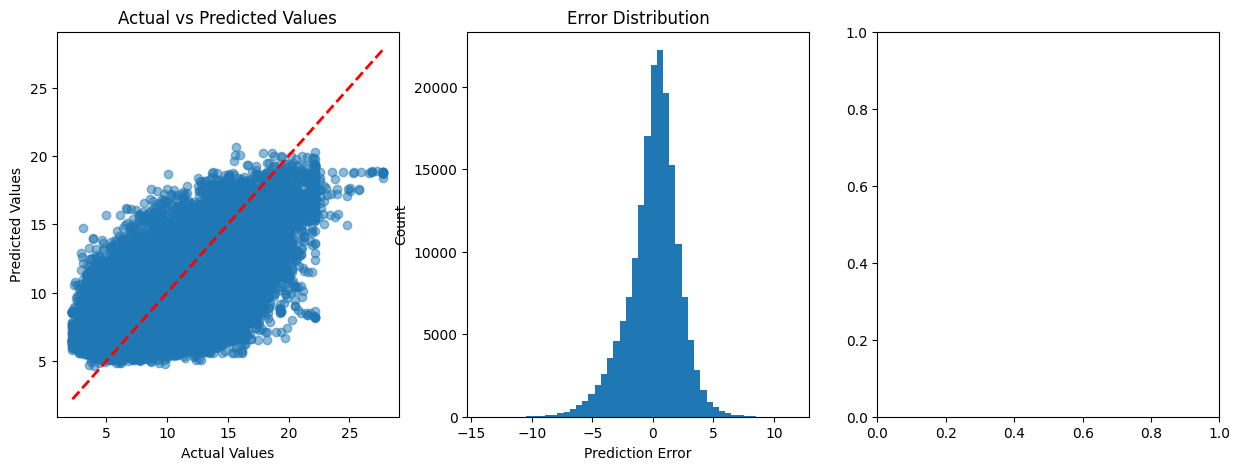

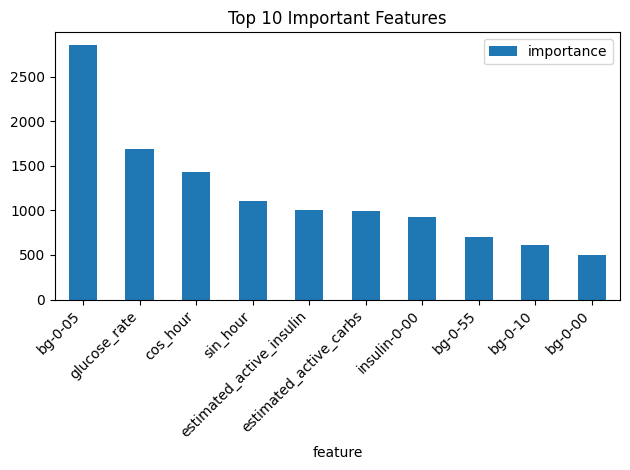


Top 10 Most Important Features:
                    feature  importance
1                    bg-0-05        2856
48              glucose_rate        1695
53                  cos_hour        1433
52                  sin_hour        1106
49  estimated_active_insulin        1005
50    estimated_active_carbs         995
12              insulin-0-00         921
11                   bg-0-55         702
2                    bg-0-10         613
0                    bg-0-00         503



In [ ]:
# LightGBM

np.random.seed(42)
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

# Define optimization objective with LightGBM parameters
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'verbosity': -1
    }

    cv = GroupKFold(n_splits=7)
    rmse_list = []

    for train_idx, valid_idx in cv.split(X, y, groups):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train,
                 eval_set=[(X_valid, y_valid)])

        y_pred = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# Run optimization
# study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print results and train final model
print("\nBest Hyperparameters:", study.best_params)

# Initialize and train final model with best parameters
final_model = lgb.LGBMRegressor(**study.best_params)

# Initialize lists for metrics
rmse_scores = []
mae_scores = []
r2_scores = []
# mard_scores = []
range_metrics = []

# # Calculate MARD
# def calculate_mard(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate range-specific metrics
def calculate_range_metrics(y_true, y_pred):
    hypo_mask = y_true < 3.9
    hypo_mae = mean_absolute_error(y_true[hypo_mask], y_pred[hypo_mask]) if hypo_mask.any() else None

    normal_mask = (y_true >= 3.9) & (y_true <= 10.0)
    normal_mae = mean_absolute_error(y_true[normal_mask], y_pred[normal_mask])

    hyper_mask = y_true > 10.0
    hyper_mae = mean_absolute_error(y_true[hyper_mask], y_pred[hyper_mask])

    return {
        'hypo_mae': hypo_mae,
        'normal_mae': normal_mae,
        'hyper_mae': hyper_mae
    }

# Cross-validation with extended metrics calculation
cv = GroupKFold(n_splits=7)
predictions = []
actuals = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):
    print(f"\nFold {fold + 1}:")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    final_model.fit(X_train, y_train,
                   eval_set=[(X_valid, y_valid)])

    y_pred = final_model.predict(X_valid)
    predictions.extend(y_pred)
    actuals.extend(y_valid)

    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)
    # mard = calculate_mard(y_valid, y_pred)
    range_met = calculate_range_metrics(y_valid, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    # mard_scores.append(mard)
    range_metrics.append(range_met)

    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R²: {r2:.3f}")
    # print(f"MARD: {mard:.3f}%")
    print("Range-specific MAE:")
    print(f"  Hypoglycemia: {range_met['hypo_mae']:.3f}" if range_met['hypo_mae'] else "  Hypoglycemia: N/A")
    print(f"  Normal range: {range_met['normal_mae']:.3f}")
    print(f"  Hyperglycemia: {range_met['hyper_mae']:.3f}")

# Print average metrics
print("\nOverall Model Performance:")
print(f"Average RMSE: {np.mean(rmse_scores):.3f} (+/- {np.std(rmse_scores):.3f})")
print(f"Average MAE: {np.mean(mae_scores):.3f} (+/- {np.std(mae_scores):.3f})")
print(f"Average R²: {np.mean(r2_scores):.3f} (+/- {np.std(r2_scores):.3f})")
# print(f"Average MARD: {np.mean(mard_scores):.3f}% (+/- {np.std(mard_scores):.3f}%)")

# Calculate average range-specific metrics
avg_hypo_mae = np.mean([m['hypo_mae'] for m in range_metrics if m['hypo_mae'] is not None])
avg_normal_mae = np.mean([m['normal_mae'] for m in range_metrics])
avg_hyper_mae = np.mean([m['hyper_mae'] for m in range_metrics])

print("\nAverage Range-specific MAE:")
print(f"Hypoglycemia: {avg_hypo_mae:.3f}")
print(f"Normal range: {avg_normal_mae:.3f}")
print(f"Hyperglycemia: {avg_hyper_mae:.3f}")

# Visualization
plt.figure(figsize=(15, 5))

# 1. Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# 2. Prediction Error Distribution
plt.subplot(1, 3, 2)
errors = np.array(predictions) - np.array(actuals)
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution')

# 3. Feature Importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.subplot(1, 3, 3)
importance_df.head(10).plot(x='feature', y='importance', kind='bar')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Important Features')

plt.tight_layout()
plt.show()

# Save importance to dataframe
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Save model
final_model.booster_.save_model('best_model.txt')

[I 2025-02-23 08:46:00,336] A new study created in memory with name: no-name-b0e21bb8-4ffe-4a1d-b224-a7bf21be0d97
[I 2025-02-23 08:50:52,820] Trial 0 finished with value: 2.1427868330666506 and parameters: {'hypo_weight': 2.2316286598964057, 'hyper_weight': 1.527476964207052}. Best is trial 0 with value: 2.1427868330666506.
[I 2025-02-23 08:55:40,263] Trial 1 finished with value: 2.2288088065294950 and parameters: {'hypo_weight': 3.27451145781001, 'hyper_weight': 1.6175016567674652}. Best is trial 0 with value: 2.1427868330666506.
[I 2025-02-23 09:00:27,163] Trial 2 finished with value: 2.1123899980896214 and parameters: {'hypo_weight': 3.3306491591303127, 'hyper_weight': 1.8326654558583222}. Best is trial 2 with value: 2.1123899980896214.
[I 2025-02-23 09:05:12,350] Trial 3 finished with value: 2.1229842745157932 and parameters: {'hypo_weight': 1.5059317233533998, 'hyper_weight': 1.8332523786715735}. Best is trial 2 with value: 2.1123899980896214.
[I 2025-02-23 09:10:01,285] Trial 4 f

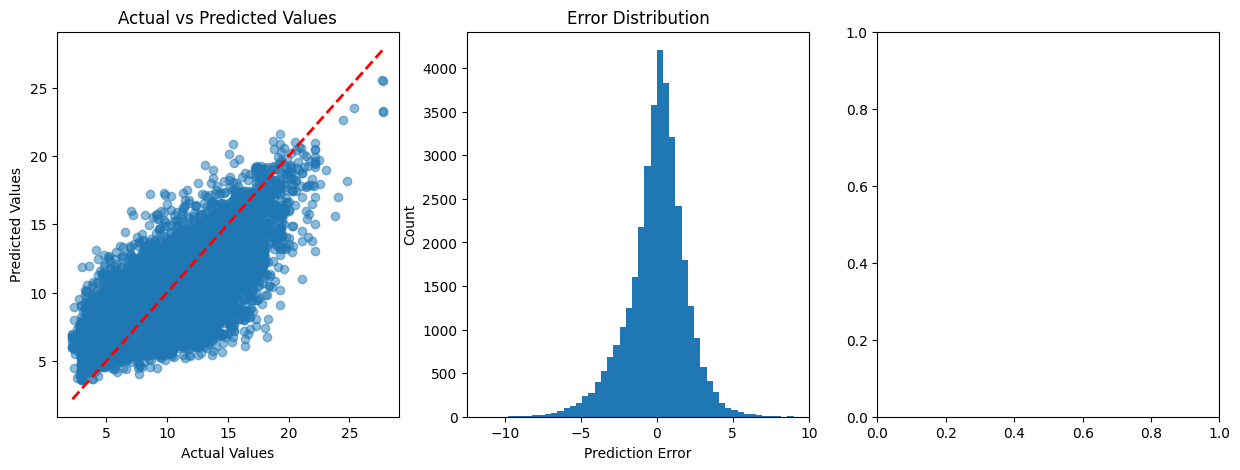

In [ ]:
# Optimized LightGBM with better hypo recognition

def generate_weights(y, hypo_weight, hyper_weight):
    return np.where(y < 3.9, hypo_weight,
           np.where(y > 10.0, hyper_weight,
                   1.0))

def objective(trial):
    param = {
        'objective': 'regression',
        'n_estimators': 842,
        'learning_rate': 0.00574,
        'max_depth': 4,
        'min_child_samples': 74,
        'subsample': 0.67,
        'colsample_bytree': 0.71,
        'reg_alpha': 0.013,
        'reg_lambda': 0.022,
        'verbosity': -1
    }

    hypo_weight = trial.suggest_float('hypo_weight', 1.5, 3.5)
    hyper_weight = trial.suggest_float('hyper_weight', 1.0, 2.0)

    cv = GroupKFold(n_splits=7)
    rmse_list = []

    for train_idx, valid_idx in cv.split(X, y, groups):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

         # Генеруємо ваги для навчального набору
        train_weights = generate_weights(y_train, hypo_weight, hyper_weight)

        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train,
                 sample_weight=train_weights,
                 eval_set=[(X_valid, y_valid)])

        y_pred = model.predict(X_valid)

         # Зважена RMSE для валідації
        valid_weights = generate_weights(y_valid, hypo_weight, hyper_weight)
        rmse = np.sqrt(np.mean(valid_weights * (y_valid - y_pred) ** 2))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Print results and train final model
print("\nBest Hyperparameters:", study.best_params)

# Initialize and train final model with best parameters
base_params = {
    'objective': 'regression',
    'n_estimators': 842,
    'learning_rate': 0.00574,
    'max_depth': 4,
    'min_child_samples': 74,
    'subsample': 0.67,
    'colsample_bytree': 0.71,
    'reg_alpha': 0.013,
    'reg_lambda': 0.022,
    'verbosity': -1
}
final_model = lgb.LGBMRegressor(**base_params)

# Initialize lists for metrics
rmse_scores = []
mae_scores = []
r2_scores = []
mard_scores = []
range_metrics = []

# Calculate MARD
def calculate_mard(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate range-specific metrics
def calculate_range_metrics(y_true, y_pred):
    hypo_mask = y_true < 3.9
    hypo_mae = mean_absolute_error(y_true[hypo_mask], y_pred[hypo_mask]) if hypo_mask.any() else None

    normal_mask = (y_true >= 3.9) & (y_true <= 10.0)
    normal_mae = mean_absolute_error(y_true[normal_mask], y_pred[normal_mask])

    hyper_mask = y_true > 10.0
    hyper_mae = mean_absolute_error(y_true[hyper_mask], y_pred[hyper_mask])

    return {
        'hypo_mae': hypo_mae,
        'normal_mae': normal_mae,
        'hyper_mae': hyper_mae
    }

# Cross-validation with extended metrics calculation
cv = GroupKFold(n_splits=7)
predictions = []
actuals = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):
    print(f"\nFold {fold + 1}:")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    train_weights = generate_weights(y_train, study.best_params['hypo_weight'], study.best_params['hyper_weight'])

    final_model.fit(X_train, y_train,
                   sample_weight=train_weights,
                   eval_set=[(X_valid, y_valid)])

    y_pred = final_model.predict(X_valid)
    predictions.extend(y_pred)
    actuals.extend(y_valid)

    # rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    # Використовуємо
    valid_weights = generate_weights(y_valid, study.best_params['hypo_weight'], study.best_params['hyper_weight'])
    rmse = np.sqrt(np.mean(valid_weights * (y_valid - y_pred) ** 2))

    mae = mean_absolute_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)
    mard = calculate_mard(y_valid, y_pred)
    range_met = calculate_range_metrics(y_valid, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    mard_scores.append(mard)
    range_metrics.append(range_met)

    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R²: {r2:.3f}")
    print(f"MARD: {mard:.3f}%")
    print("Range-specific MAE:")
    print(f"  Hypoglycemia: {range_met['hypo_mae']:.3f}" if range_met['hypo_mae'] else "  Hypoglycemia: N/A")
    print(f"  Normal range: {range_met['normal_mae']:.3f}")
    print(f"  Hyperglycemia: {range_met['hyper_mae']:.3f}")

# Print average metrics
print("\nOverall Model Performance:")
print(f"Average RMSE: {np.mean(rmse_scores):.3f} (+/- {np.std(rmse_scores):.3f})")
print(f"Average MAE: {np.mean(mae_scores):.3f} (+/- {np.std(mae_scores):.3f})")
print(f"Average R²: {np.mean(r2_scores):.3f} (+/- {np.std(r2_scores):.3f})")
print(f"Average MARD: {np.mean(mard_scores):.3f}% (+/- {np.std(mard_scores):.3f}%)")

# Calculate average range-specific metrics
avg_hypo_mae = np.mean([m['hypo_mae'] for m in range_metrics if m['hypo_mae'] is not None])
avg_normal_mae = np.mean([m['normal_mae'] for m in range_metrics])
avg_hyper_mae = np.mean([m['hyper_mae'] for m in range_metrics])

print("\nAverage Range-specific MAE:")
print(f"Hypoglycemia: {avg_hypo_mae:.3f}")
print(f"Normal range: {avg_normal_mae:.3f}")
print(f"Hyperglycemia: {avg_hyper_mae:.3f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

plt.subplot(1, 3, 2)
errors = np.array(predictions) - np.array(actuals)
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution')